## Section 3: Hierarchal modeling
A key strength of bayesian modeling is the easy and flexibility in which one can implement an hierarchal model. This section will implement and compare a pooled vs partially pooled model.

In [5]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import seaborn.apionly as sns

from sklearn import preprocessing

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('data/hangout_chat_data.csv')

### Model Pooling
Lets explore a different way of modeling the response time for my hangout conversations. My intuition would suggest that my tendancy to reply quickly to a chat depends on who I'm talking to. I might be more likely to respond quickly to my girl friend than a distant friend. As such, I could decide to model each conversation independently, estimating parameters $\mu_i$ and $\alpha_i$ for each conversation $i$.

One consideration we must make, is that some conversations have very few messages compared to others. As such, our estimates of response time for conversations with few messages will have a higher degree of uncertinity than conversations with a large number of messages. The below plot illustrates the discrepancy in sample size per conversation.

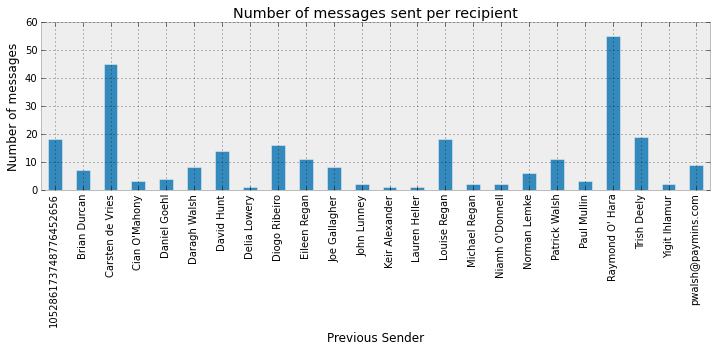

In [6]:
ax = messages.groupby('prev_sender')['conversation_id'].size().plot(
    kind='bar', figsize=(12,3), title='Number of messages sent per recipient')
_ = ax.set_xlabel('Previous Sender')
_ = ax.set_ylabel('Number of messages')
_ = plt.xticks(rotation=90)

For each message j and each conversation i, we represent the model as:

$$y_{ji} \sim NegBinomial(\mu_i, \alpha_i)$$
$$\mu_i = Uniform(0, 100)$$
$$\alpha_i = Uniform(0, 100)$$

In [28]:
indiv_traces = {}

# Convert categorical variables to integer
le = preprocessing.LabelEncoder()
participants_idx = le.fit_transform(messages['prev_sender'])
participants = le.classes_
n_participants = len(participants)

for p in participants:
    with pm.Model() as model:
        alpha = pm.Uniform('alpha', lower=0, upper=100)
        mu = pm.Uniform('mu', lower=0, upper=100)
        
        data = messages[messages['prev_sender']==p]['time_delay_seconds']
        y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=data)

        y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)
        
        start = pm.find_MAP()
        step = pm.Metropolis()
        trace = pm.sample(20000, step, start=start, progressbar=True)
        
        indiv_traces[p] = trace

 [-----------------100%-----------------] 20000 of 20000 complete in 4.8 sec

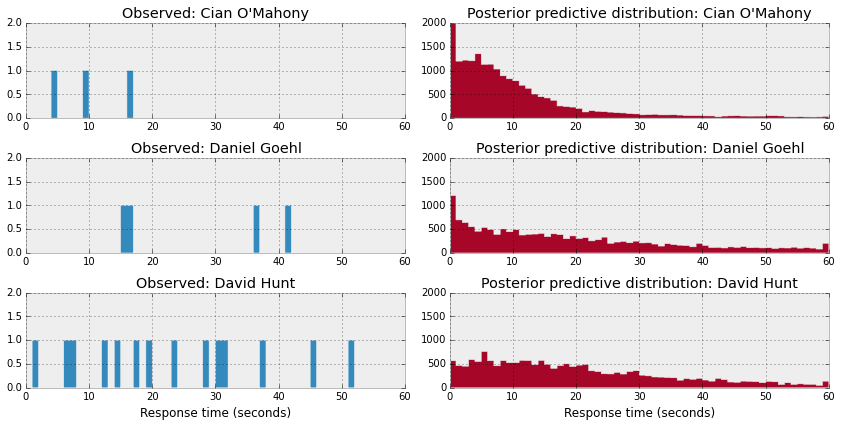

In [29]:
fig, axs = plt.subplots(3,2, figsize=(12, 6))
axs = axs.ravel()
y_left_max = 2
y_right_max = 2000
x_lim = 60
ix = [3,4,6]

for i, j, p in zip([0,1,2], [0,2,4], participants[ix]):
    axs[j].set_title('Observed: %s' % p)
    axs[j].hist(messages[messages['prev_sender']==p]['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
    axs[j].set_ylim([0, y_left_max])

for i, j, p in zip([0,1,2], [1,3,5], participants[ix]):
    axs[j].set_title('Posterior predictive distribution: %s' % p)
    axs[j].hist(indiv_traces[p].get_values('y_pred'), range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])
    axs[j].set_ylim([0, y_right_max])

axs[4].set_xlabel('Response time (seconds)')
axs[5].set_xlabel('Response time (seconds)')

plt.tight_layout()

The above plots show the observed data (left) and the posterior predictive distribution (right) for 3 example conversations we modeled. As you can see, the posterior predictive distribution can vary considerably across conversations. This could accurately reflect the characteristics of the conversation or it could be inaccurate due to small sample size.

If we combine the posterior predictive distributions across these models, we would expect this to resemble the distribution of the overall dataset observed. Lets perform the posterior predictive check.

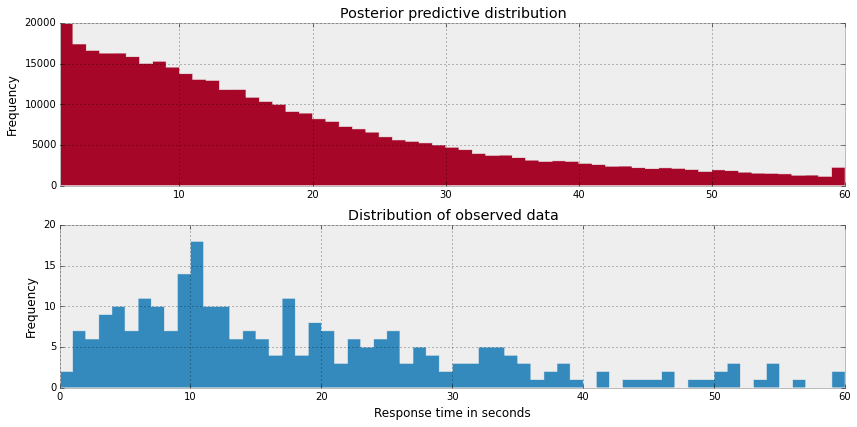

In [30]:
combined_y_pred = np.concatenate([v.get_values('y_pred') for k, v in indiv_traces.iteritems()])

x_lim = 60
y_pred = trace.get_values('y_pred')

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(combined_y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylim(0, 20000)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlim(0, x_lim)
_ = plt.xlabel('Response time in seconds')
_ = plt.ylim(0, 20)
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

TODO: Above plot is not accurate. 

Yes, the posterior predictive distribution resembles the distribution of the observed data. However, I'm concerned that some of the conversations have very little data and hence the estimates are likely to have high variance. One way to mitigate this risk to to share information across conversations - but still estimate $\mu_i$ for each conversation. We call this partial pooling.

### Partial pooling
One of the best aspects of Bayesian modeling is the flexibility of which one can create hierarchal models. Partial modeling is a great way to model this hierarchal dependancy. I will estimate  parameters $(\mu_i)$ and $(\alpha_i)$ for each conversation i. We represent the model as:

$$y_{ji} \sim NegBinomial(\mu_i, \alpha_i)$$
$$\mu_i = Gamma(\tau_\mu, \gamma_\mu)$$
$$\alpha_i = Gamma(\tau_\alpha, \gamma_\alpha)$$
$$\tau_\mu = Uniform(0, 60)$$
$$\gamma_\mu = Uniform(0, 50)$$
$$\tau_\alpha = Uniform(0, 10)$$
$$\gamma_\alpha = Uniform(0, 50)$$

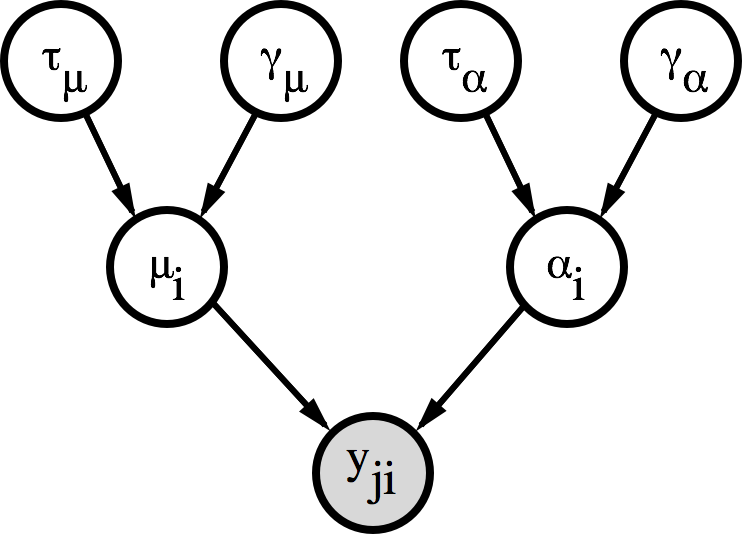

In [31]:
from IPython.display import Image
Image('graphics/dag-partial-pooled-model.png', width=380)

In [32]:
with pm.Model() as model:
    hyper_alpha_delta = pm.Uniform('hyper_alpha_delta', lower=0, upper=50)
    hyper_alpha_mu = pm.Uniform('hyper_alpha_mu', lower=0, upper=10)
    
    hyper_mu_delta = pm.Uniform('hyper_mu_delta', lower=0, upper=50)
    hyper_mu_mu = pm.Uniform('hyper_mu_mu', lower=0, upper=60)
    
    alpha = pm.Gamma('alpha', alpha=hyper_alpha_mu**2/hyper_alpha_delta**2, 
                     beta=hyper_alpha_mu/hyper_alpha_delta**2, shape=n_participants)
    mu = pm.Gamma('mu', alpha=hyper_mu_mu**2/hyper_mu_delta**2, 
                  beta=hyper_mu_mu/hyper_mu_delta**2, shape=n_participants)
    
    y_est = pm.NegativeBinomial('y_est', 
                                mu=mu[participants_idx], 
                                alpha=alpha[participants_idx], 
                                observed=messages['time_delay_seconds'].values)
    
    y_pred = pm.NegativeBinomial('y_pred', 
                                 mu=mu[participants_idx], 
                                 alpha=alpha[participants_idx],
                                 shape=messages['prev_sender'].shape)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    hierarchical_trace = pm.sample(200000, step, progressbar=True)

 [-----------------100%-----------------] 200000 of 200000 complete in 190.9 sec

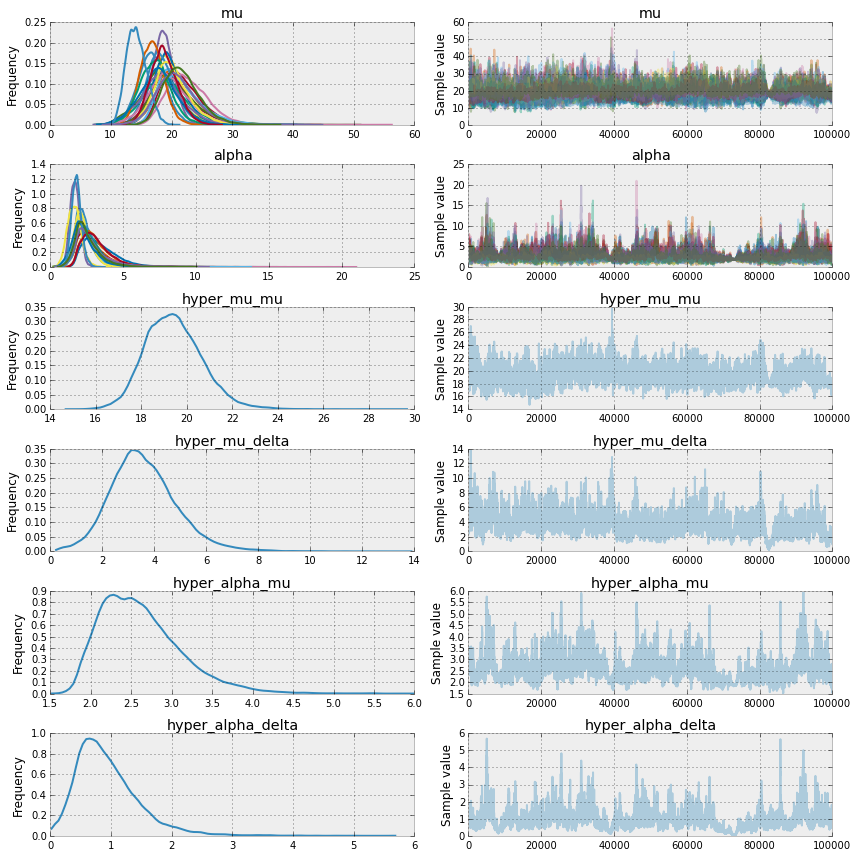

In [33]:
_ = pm.traceplot(hierarchical_trace[100000:], 
                 vars=['mu','alpha','hyper_mu_mu',
                       'hyper_mu_delta','hyper_alpha_mu',
                       'hyper_alpha_delta'])

You can see for the estimates of $\mu$ and $\alpha$ that we have multiple plots - one for each conversation i. The difference between the pooled and the partially pooled model, is that the parameters of teh partially pooled model ($\mu_i$ and $\alpha_i$) have a hyper parameter that is shared across all conversations i. This brings two benefits:
1. Information is shared across conversations so for conversations that have limited sample size, they "borrow" knowledge from other conversations during estimation to help reduce the variance of the estimate
2. We get an estimate for each conversation and an overall estimate for all conversations

Let's have a quick look at the posterior predictive distribution.

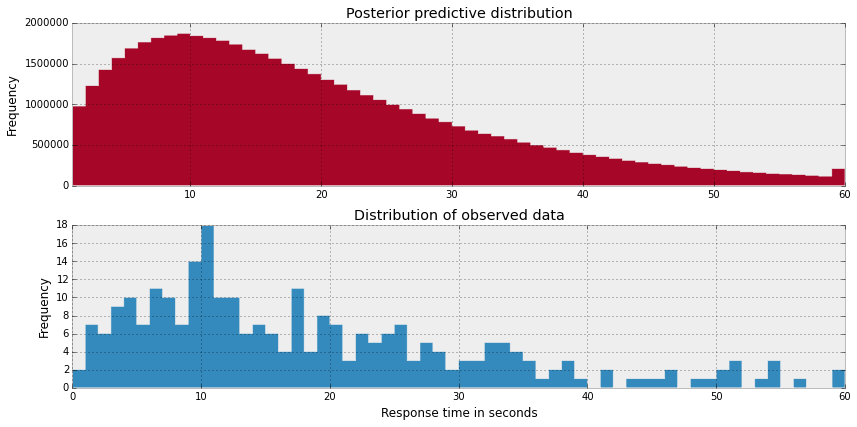

In [34]:
x_lim = 60
y_pred = hierarchical_trace.get_values('y_pred').ravel()

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

### Shrinkage effect: pooled vs hierarchal model
As discussed, the partially pooled model shared a hyper parameter for both $\mu$ and $\alpha$. By sharing knowledge across conversations, it has the effect of shrinking the estimates closer towether - particularly for conversations that have little data.

This shrinkage effect is illustrated in the below plot. You can see how the $\mu$ and $\alpha$ parameters are drawn together by the effect of the hyperparameter.

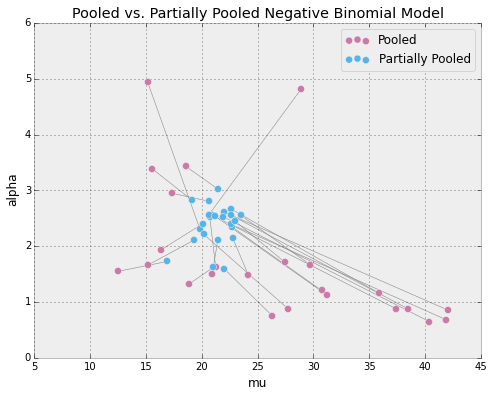

In [48]:
hier_mu = hierarchical_trace['mu'][500:].mean(axis=0)
hier_alpha = hierarchical_trace['alpha'][500:].mean(axis=0)
indv_mu = [indiv_traces[p]['mu'][500:].mean() for p in participants]
indv_alpha = [indiv_traces[p]['alpha'][500:].mean() for p in participants]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlabel='mu', ylabel='alpha', 
                     title='Pooled vs. Partially Pooled Negative Binomial Model', 
                     xlim=(5, 45), ylim=(0, 6))

ax.scatter(indv_mu, indv_alpha, c=colors[5], s=50, label = 'Pooled', zorder=3)
ax.scatter(hier_mu, hier_alpha, c=colors[6], s=50, label = 'Partially Pooled', zorder=4)
for i in range(len(indv_mu)):  
    ax.arrow(indv_mu[i], indv_alpha[i], hier_mu[i] - indv_mu[i], hier_alpha[i] - indv_alpha[i], 
            fc="grey", ec="grey", length_includes_head=True, alpha=.5, head_width=0)

_ = ax.legend()

### Asking questions of the posterior
Lets start to take advantage of one of the best aspects of bayesian statistics - the posterior distribution. Unlike frequentist techniques, we get a full posterior distribution as opposed to a single point estimate. In essence, we have a basket full of credible parameter values. This enables us to ask some questions in a fairly natural and intuitive manner.

#### What are the chances I'll respond to mom in less than 10 seconds?

To estimate this probability, we can look at the posterior predctive distribution for response times to Eileen's messages and check how many of the samples are < 10 seconds.

In [36]:
def participant_y_pred(person):
    """Return posterior predictive for person"""
    ix = np.where(participants == person)[0][0]
    return hierarchical_trace['y_pred'][:, ix]

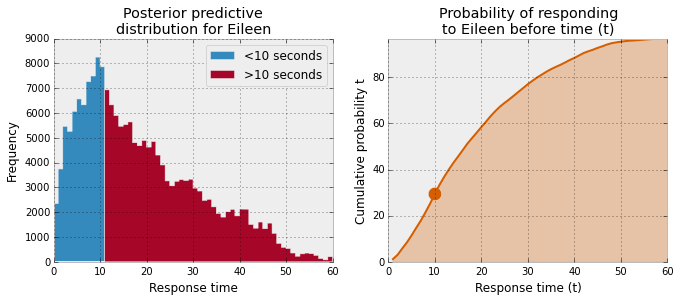

In [37]:
ix_check = participant_y_pred('Eileen Regan') > 10
fig = plt.figure(figsize=(11,4))
_ = fig.add_subplot(121)
_ = plt.hist(participant_y_pred('Eileen Regan')[~ix_check], range=[0, x_lim], bins=x_lim, histtype='stepfilled', label='<10 seconds')
_ = plt.hist(participant_y_pred('Eileen Regan')[ix_check], range=[0, x_lim], bins=x_lim, histtype='stepfilled', label='>10 seconds')
_ = plt.title('Posterior predictive \ndistribution for Eileen')
_ = plt.xlabel('Response time')
_ = plt.ylabel('Frequency')
_ = plt.legend()

fig.add_subplot(122)
x = np.linspace(1, 60, num=60)
num_samples = float(len(participant_y_pred('Eileen Regan')))
prob_lt_x = [100*sum(participant_y_pred('Eileen Regan') < i)/num_samples for i in x]
_ = plt.plot(x, prob_lt_x, color=colors[4])
_ = plt.fill_between(x, prob_lt_x, color=colors[4], alpha=0.3)
_ = plt.scatter(10, float(100*sum(participant_y_pred('Eileen Regan') < 10))/num_samples, s=180, c=colors[4])
_ = plt.title('Probability of responding \nto Eileen before time (t)')
_ = plt.xlabel('Response time (t)')
_ = plt.ylabel('Cumulative probability t')
_ = plt.ylim(ymin=0, ymax=np.max(prob_lt_x))
_ = plt.xlim(xmin=0, xmax=60)

I find this methodology to be very intuitive and flexible. The plot above left separates the samples from the posterior predictive in terms of being less than or greater than or equal to 10 seconds. We can compute the probability of simply summing up the count of BLUE and divinging by the count of RED + BLUE. The plot on the right simply computes this probability for each response time value from 0 to 60.

#### How do my friends pair off against each other?

In [38]:
# Identify the 5 people I'm most likely to respond slowest
def prob_persona_faster(persona, personb):
    return sum(participant_y_pred(persona) < participant_y_pred(personb))/num_samples

print "Probability that Eileen is responded to faster than Joe: %s" % prob_persona_faster('Eileen Regan', 'Joe Gallagher')

Probability that Eileen is responded to faster than Joe: 0.508495


In [40]:
# Create an empty dataframe
ab_dist_df = pd.DataFrame(index=participants, columns=participants, dtype=np.float)

# populate each cell in dataframe with persona_less_personb()
for a, b in itertools.permutations(participants, 2):
    ab_dist_df.ix[a, b] = prob_persona_faster(a, b)
    
# populate the diagonal
for a in participants:
    ab_dist_df.ix[a, a] = 0.5

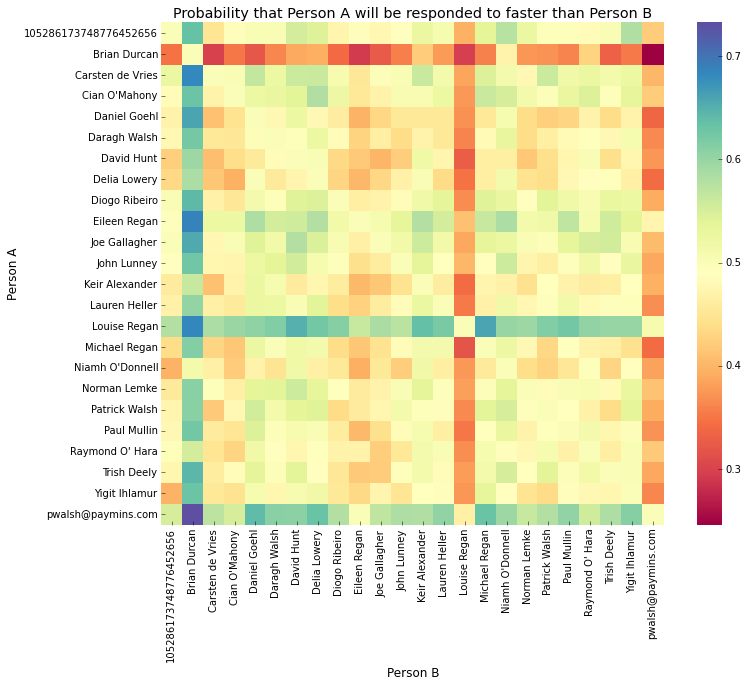

In [42]:
# Plot distace matrix
f, ax = plt.subplots(figsize=(12, 9))
cmap = plt.get_cmap("Spectral")
_ = sns.heatmap(ab_dist_df, square=True, cmap=cmap)
_ = plt.title('Probability that Person A will be responded to faster than Person B')
_ = plt.ylabel('Person A')
_ = plt.xlabel('Person B')

### References
1. [The Best Of Both Worlds: Hierarchical Linear Regression in PyMC3](http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/) by Thomas Wiecki

In [166]:
# Apply pretty styles
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()